# Debugging:
## This script imports C and Python HDF output for comparison

In [123]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import subprocess

## Converter

Converts all hdf4 output of RKLM C-code to hdf5.

In [166]:
base_folder_name = "output"

#####################################################
#
# C-output folder names
#
# base_suffix = '_acoustic_wave_high/'
# base_suffix = '_internal_long_wave/'
# base_suffix = '_travelling_vortex_3d_48_no_initial_projection/'
base_suffix = '_travelling_vortex_3d_48_with_initial_projection/'
#
#####################################################

base_path = base_folder_name + base_suffix
folder_comp = "low_Mach_gravity_comp/"
folder_psinc = "low_Mach_gravity_psinc/"

# Manually list the folder names for each output
directories = ['S', 'T', 'Y', 'buoy', 'dT', 'dY', 'dp2_c', 'dp2_nodes', 'dpdim', 'drhoY', 'p', 'p2_c', 'p2_nodes', 'rho', 'rhoY', 'rhoe', 'u', 'v', 'vortz', 'w']
directories += ['rhou', 'rhov', 'rhow']

directories += ['flux_x']
# directories += ['wplusx', 'wplusy', 'pnew', 'hcenter']

# And manually list the file names.
filenames = ['S', 'T', 'Y', 'buoy', 'dT', 'dY', 'dp2_c', 'dp2_n', 'dpdim', 'drhoY', 'p', 'p2_c', 'p2_n', 'rho', 'rhoY', 'rhoe', 'u', 'v', 'vortz', 'w']
filenames += ['rhou', 'rhov', 'rhow']

filenames += ['rhoYu']
# filenames += ['wplusx', 'wplusy', 'pnew', 'hcenter']

# specify the format extensions for input and output of converter
hdf_format = '.'+ 'hdf'
h5_format = '.' + 'h5'

# time-tag to convert.
time = '000'

string_hdf = '_' + time + hdf_format
string_h5 = '_' + time + h5_format
full_path = base_path + folder_comp

lst_hdf = []
lst_h5 = []

# build list of paths from parameters specified above.
i = 0
for directory in directories:
    lst_hdf.append(full_path + directory + '/' + filenames[i] + string_hdf)
    lst_h5.append(full_path + directory + '/' + filenames[i] + string_h5)
    i += 1 

# print the list of paths
for path in lst_hdf:
    print(path)

# now, convert the arrays specified in the list of paths
for item in lst_hdf:
    p = subprocess.call(["./h4toh5convert", item])

output_travelling_vortex_3d_48_with_initial_projection/low_Mach_gravity_comp/S/S_000.hdf
output_travelling_vortex_3d_48_with_initial_projection/low_Mach_gravity_comp/T/T_000.hdf
output_travelling_vortex_3d_48_with_initial_projection/low_Mach_gravity_comp/Y/Y_000.hdf
output_travelling_vortex_3d_48_with_initial_projection/low_Mach_gravity_comp/buoy/buoy_000.hdf
output_travelling_vortex_3d_48_with_initial_projection/low_Mach_gravity_comp/dT/dT_000.hdf
output_travelling_vortex_3d_48_with_initial_projection/low_Mach_gravity_comp/dY/dY_000.hdf
output_travelling_vortex_3d_48_with_initial_projection/low_Mach_gravity_comp/dp2_c/dp2_c_000.hdf
output_travelling_vortex_3d_48_with_initial_projection/low_Mach_gravity_comp/dp2_nodes/dp2_n_000.hdf
output_travelling_vortex_3d_48_with_initial_projection/low_Mach_gravity_comp/dpdim/dpdim_000.hdf
output_travelling_vortex_3d_48_with_initial_projection/low_Mach_gravity_comp/drhoY/drhoY_000.hdf
output_travelling_vortex_3d_48_with_initial_projection/low_Mach_

## Import C hdf5 output

Import the test case arrays from the c-output.

In [174]:
# manually specific folder names
test_cases_folders = ['p2_c', 'dp2_nodes', 'p', 'p2_nodes', 'rho', 'rhoY', 'rhoe', 'rhou', 'rhov', 'rhow', 'u', 'vortz', 'dpdim', 'T', 'dT', 'Y', 'dY', 'dp2_c']
# test_cases_folders += ['wplusx', 'wplusy', 'pnew', 'hcenter']

test_cases_folders += ['flux_x']
test_cases_folders = np.char.array(test_cases_folders)

# and filenames
test_cases_names = ['p2_c', 'dp2_n', 'p', 'p2_n', 'rho', 'rhoY', 'rhoe', 'rhou', 'rhov', 'rhow', 'u', 'vortz', 'dpdim', 'T', 'dT', 'Y', 'dY', 'dp2_c']
# test_cases_names += ['wplusx', 'wplusy', 'pnew', 'hcenter']

test_cases_names += ['rhoYu']
test_cases_names = np.char.array(test_cases_names)

# build paths from folder names and filenames
test_cases_paths = full_path + test_cases_folders + '/' + test_cases_names + string_h5

# define empty class as a holder for all the C-hdf5 output.
class c_output(object):
    def __init__(self):
        None
        
    def c_out(self):
        for key,value in vars(self).items():
            setattr(self,key,value['Data-Set-2'])

## Import the Python output

In [173]:
# specify directory where the python hdf5 output is.
# py_directory = "../RKLM_Python/"
py_directory = "../"

#####################################################
#
# and its filename
#
# py_filename = "output_acoustic_wave_high_low_mach_gravity_comp.h5"
# py_filename = "output_internal_long_wave_low_mach_gravity_comp.h5"
py_filename = "output_travelling_vortex_3d_48_low_mach_gravity_comp.h5"
#
#####################################################

py_path = py_directory + py_filename

# helper function to extract array from hdf file by its name and timestep
def py_out(py_dataset,time='_000'):
    return pyfile[str(py_dataset)][str(py_dataset)+time][:]

## Helper diagnostic functions

In [225]:
# print an array
def p(obj):
    print(obj)
    
# visualise an array
def v(obj):
    plt.imshow(obj)
    plt.colorbar()
    plt.show()
    
# plot a slice of the array, default is x = 0 for all y (slice at origin)
def s(obj,slc=(slice(None))):
    plt.plot(obj['Data-Set-2'][slc])
    plt.show()
    
# plot the difference between the C and Python outputs
def diff(obj_c, obj_py, title):
    obj_c = obj_c[2:-2,2:-2]
#     obj_c -= obj_c.mean()
    obj_py = obj_py[2:-2,2:-2]
#     obj_py -= obj_py.mean()
#     
    c_range = np.max(obj_c) - np.min(obj_c)
    py_range = np.max(obj_py) - np.min(obj_py)
    max_norm = np.abs(obj_c - obj_py)
    
    max_diff = np.max(max_norm)
    
    fig, ax = plt.subplots(ncols=3, figsize=(12,3))
    # plot c array
    im_c = ax[0].imshow(obj_c, label="c")
    fig.colorbar(im_c,ax=ax[0])
    ax[0].set_title("c")
    ax[0].set_aspect('auto')
    
    # plot python array
    im_py = ax[1].imshow(obj_py, label="py")
    fig.colorbar(im_py,ax=ax[1])
    ax[1].set_title("py")
    ax[1].set_aspect('auto')

    # plot the difference between the two
    im_diff = ax[2].imshow(max_norm, label="diff")
    fig.colorbar(im_diff,ax=ax[2])
    ax[2].set_title("diff")
    ax[2].set_aspect('auto')
    
    # calculate the max difference relative to the C-output for non-zero values.
    if c_range == 0.0:
        rel_diff = 0.0
    else:
        rel_diff = max_diff/c_range
        
    print("comparison = %s,\nc_range = %e, py_range = %e, \nmax diff = %e, rel. diff = %e," %(title, c_range, py_range, max_diff, rel_diff))
    plt.tight_layout(h_pad=1)
    plt.show()
    print("################################################## \n")

In [226]:
# get an instance of an empty class to populate it with the C-HDF output as attributes
c = c_output()

# populate the class with the C-HDF output as attributes
i = 0
for path in test_cases_paths:
    setattr(c,test_cases_folders[i],h5py.File(path, 'r'))
    i += 1
    
# run the method to extract array from HDF objects
c.c_out()

In [177]:
# # open the Python HDF file
# pyfile = h5py.File(py_path, 'r')

# # print(py_out('wplusx'))

# # print(c.pnew[:])
# # print(py_out('p2')[:])

# # diff(c.wplusx,py_out('wplusx'),'wplusx')
# # diff(c.wplusy,py_out('wplusy'),'wplusy')
# # diff(c.hcenter,py_out('hcenter'),'hcenter')
# # diff(c.pnew,py_out('p2'),'p2')
# # diff(c.pnew,py_out('p2'),'p2')


# # inner_domain = np.empty((2), dtype=object)
# # inner_domain = (slice(2,50),slice(2,50))
# # reshaper = c.wplusx[:].reshape(-1,)
# # reshaper = reshaper[:53**2]
# # reshaper = reshaper.reshape(53,53)
# # inner_domain = (slice(None,), slice(None,))
# # # print(c.wplusx[:][inner_domain].shape)
# # # plt.imshow(c.wplusx[:][inner_domain])
# # print(reshaper.shape)
# # plt.imshow(reshaper)
# # plt.colorbar()
# # plt.show()

# # plt.imshow(c.wplusy[:])
# # plt.colorbar()
# # plt.show()

# # plt.imshow(py_out('wplusx'))
# # plt.colorbar()
# # plt.show()

# plt.imshow(c.pnew[:])
# plt.colorbar()
# plt.show()

# pyfile.close()

comparison = p2_nodes,
c_range = 5.705084e-03, py_range = 5.705084e-03, 
max diff = 0.000000e+00, rel. diff = 0.000000e+00,


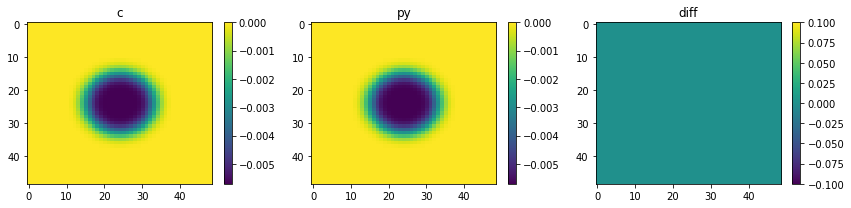

################################################## 

comparison = rho,
c_range = 4.959447e-01, py_range = 4.959447e-01, 
max diff = 0.000000e+00, rel. diff = 0.000000e+00,


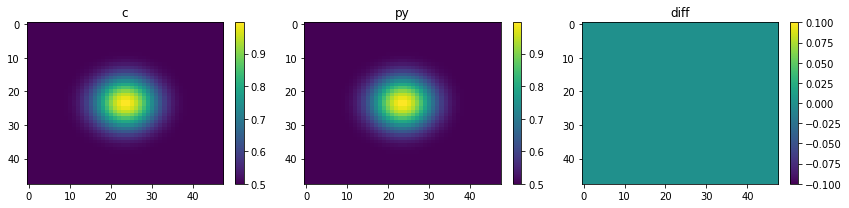

################################################## 

comparison = rhoY,
c_range = 1.788139e-07, py_range = 1.788139e-07, 
max diff = 0.000000e+00, rel. diff = 0.000000e+00,


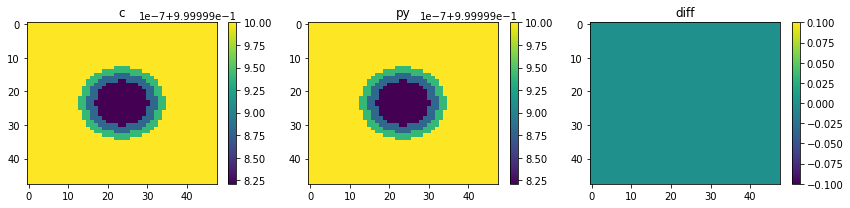

################################################## 

comparison = rhou,
c_range = 5.693929e-01, py_range = 5.693930e-01, 
max diff = 5.960464e-08, rel. diff = 1.046810e-07,


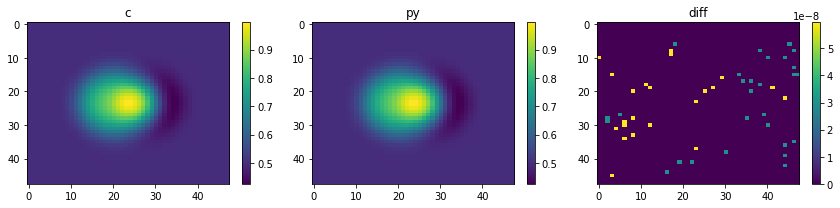

################################################## 

comparison = u,
c_range = 4.998215e-01, py_range = 4.998215e-01, 
max diff = 1.192093e-07, rel. diff = 2.385037e-07,


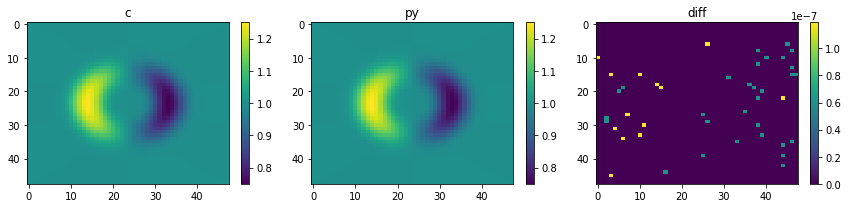

################################################## 

comparison = vortz,
c_range = 6.074564e+00, py_range = 6.074564e+00, 
max diff = 1.192093e-07, rel. diff = 1.962434e-08,


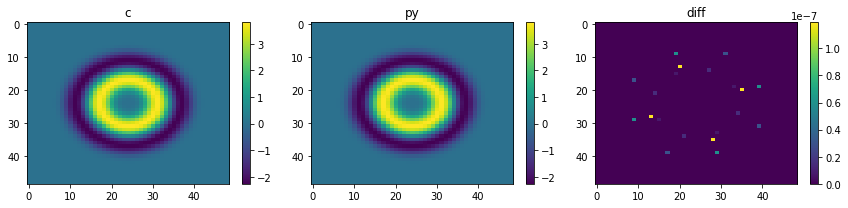

################################################## 



In [227]:
# open the Python HDF file
pyfile = h5py.File(py_path, 'r')

# make comparisons for the arrays.
# Arguments: C-array (class attribute), Python-array (numpy array), and a title.
# PPP = np.copy(py_out('dp2_nodes'))
# PPP[:,-4:-2] = py_out('dp2_nodes')[:,2:4][::-1]

# diff(c.pnew, PPP, 'dp2_nodes')

diff(c.pnew,py_out('dp2_nodes'),'dp2_nodes')
diff(c.p2_nodes,py_out('p2_nodes'),'p2_nodes')
diff(c.dp2_c,py_out('dp2_cells'),'dp2_cells')
diff(c.p2_c,py_out('p2_cells'),'p2_cells')

diff(c.rho,py_out('rho'),'rho')
# diff(c.rhoe,py_out('rhoe'),'rhoe')
diff(c.rhoY,py_out('rhoY'),'rhoY')

diff(c.rhou,py_out('rhou'),'rhou')
# diff(c.rhov,py_out('rhov'),'rhov')
# diff(c.rhow,py_out('rhow'),'rhow')

diff(c.u, py_out('u'), 'u')
# diff(c.p, py_out('p'), 'p')
# diff(c.dpdim, py_out('dpdim'), 'dpdim')
diff(c.vortz, py_out('vortz'), 'vortz')

diff(c.T, py_out('T'), 'T')
diff(c.dT, py_out('dT'), 'dT')

diff(c.Y, py_out('Y'), 'Y')
diff(c.dY, py_out('dY'), 'dY')

pyfile.close()

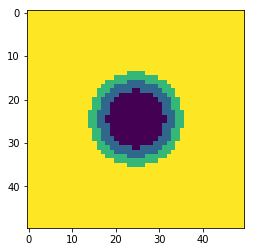

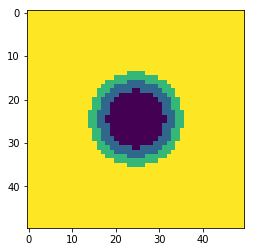

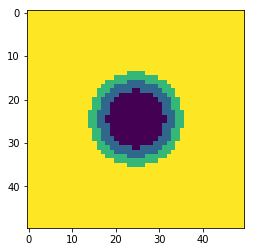

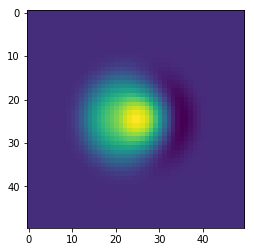

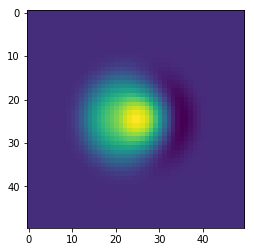

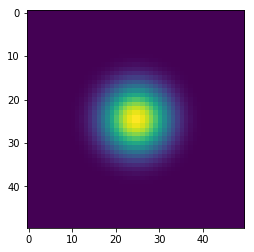

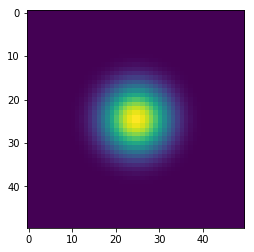

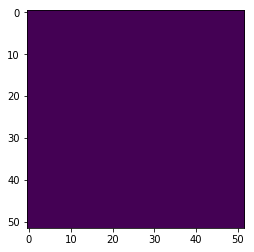

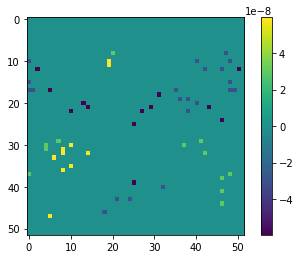

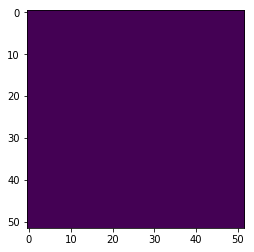

In [255]:
directory = 'flux_x'
filename = 'rhoY'
time = '_000'
string_hdf = time + '.hdf'
string_h5 = time + '.h5'
item = full_path + directory + '/' + filename + string_hdf


subprocess.call(["./h4toh5convert", item])
item_h5 = full_path + directory + '/' + filename + string_h5

Sol_rhoY = h5py.File(item_h5, 'r')
Sol_rhoY = Sol_rhoY['Data-Set-2'][:]

directory = 'flux_x'
filename = 'rhou'
time = '_000'
string_hdf = time + '.hdf'
string_h5 = time + '.h5'
item = full_path + directory + '/' + filename + string_hdf


subprocess.call(["./h4toh5convert", item])
item_h5 = full_path + directory + '/' + filename + string_h5

Sol_rhou = h5py.File(item_h5, 'r')
Sol_rhou = Sol_rhou['Data-Set-2'][:]

directory = 'flux_x'
filename = 'rho'
time = '_000'
string_hdf = time + '.hdf'
string_h5 = time + '.h5'
item = full_path + directory + '/' + filename + string_hdf


subprocess.call(["./h4toh5convert", item])
item_h5 = full_path + directory + '/' + filename + string_h5

Sol_rho = h5py.File(item_h5, 'r')
Sol_rho = Sol_rho['Data-Set-2'][:]


directory = 'rhoY'
filename = 'rhoY'
time = '_000'
string_hdf = time + '.hdf'
string_h5 = time + '.h5'
item = full_path + directory + '/' + filename + string_hdf

subprocess.call(["./h4toh5convert", item])
item_h5 = full_path + directory + '/' + filename + string_h5

Sol_rhoYY = h5py.File(item_h5, 'r')
Sol_rhoYY = Sol_rhoYY['Data-Set-2'][:]

pyfile = h5py.File(py_path, 'r')
p_rhoY = py_out('rhoY')
pyfile.close()

pyfile = h5py.File(py_path, 'r')
p_rhou = py_out('rhou')
pyfile.close()

pyfile = h5py.File(py_path, 'r')
p_rho = py_out('rho')
pyfile.close()

plt.imshow(Sol_rhoY[1:-1,1:-1])
plt.show()
plt.imshow(Sol_rhoYY[1:-1,1:-1])
plt.show()
plt.imshow(p_rhoY[1:-1,1:-1])
plt.show()

plt.imshow(Sol_rhou[1:-1,1:-1])
plt.show()
plt.imshow(p_rhou[1:-1,1:-1])
plt.show()

plt.imshow(Sol_rho[1:-1,1:-1])
plt.show()
plt.imshow(p_rho[1:-1,1:-1])
plt.show()


plt.imshow(Sol_rhoY - p_rhoY)
plt.show()
plt.imshow(Sol_rhou - p_rhou)
plt.colorbar()
plt.show()
plt.imshow(Sol_rho - p_rho)
plt.show()

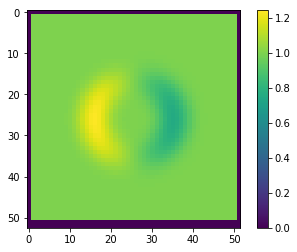

1.2420081 0.0
1368


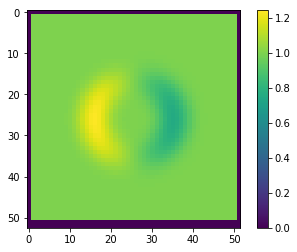

1.2420081 0.0
1368
1.2407817
243


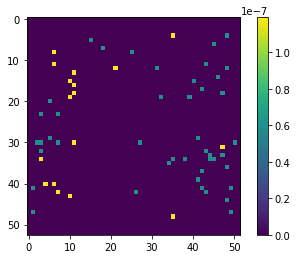

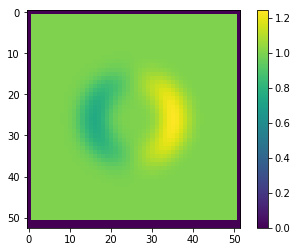

1.2420081


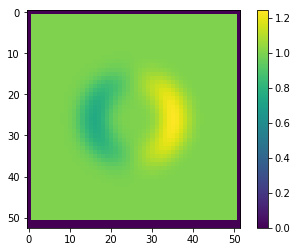

1.2420081


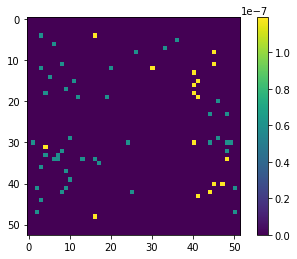

In [265]:
directory = 'flux_x'
filename = 'rhoYu'
time = '_000'
string_hdf = time + '.hdf'
string_h5 = time + '.h5'
item = full_path + directory + '/' + filename + string_hdf


subprocess.call(["./h4toh5convert", item])
item_h5 = full_path + directory + '/' + filename + string_h5

array = h5py.File(item_h5, 'r')
array = array['Data-Set-2'][:]

plt.imshow(array)
plt.colorbar()
plt.show()
print(array.max(), array.min())
print(np.argmax(array))

pyfile = h5py.File(py_path, 'r')

p_array = py_out('rhoYu','_000')

plt.imshow(p_array)
plt.colorbar()
plt.show()
print(p_array.max(), p_array.min())
print(np.argmax(p_array))
print(p_array.flatten()[1316])

plt.imshow(np.abs(array - p_array))
print(np.argmax(np.abs(array - p_array)))
plt.colorbar()
plt.show()

directory = 'flux_y'
filename = 'rhoYv'
time = '_000'
string_hdf = time + '.hdf'
string_h5 = time + '.h5'
item = full_path + directory + '/' + filename + string_hdf


subprocess.call(["./h4toh5convert", item])
item_h5 = full_path + directory + '/' + filename + string_h5

array = h5py.File(item_h5, 'r')
array = array['Data-Set-2'][:]

plt.imshow(array)
plt.colorbar()
plt.show()
print(array.max())

p_array = py_out('rhoYv','_000')

plt.imshow(p_array.T)
plt.colorbar()
plt.show()
print(p_array.max())

plt.imshow(np.abs(array - p_array.T))
plt.colorbar()
plt.show()

pyfile.close()

In [38]:
pyfile.close()

In [270]:
for i in range(2,3):
    print(i)

2
